In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import trange
import torch

In [2]:
# nifti file load
def read_nii_file(nii_path):
    '''
    根据路径读取文件
    '''
    nii_img=nib.load(nii_path)
    # 可以获取很多信息包括shape，仿射值，数据类型和矩阵
    # print(nii_img)
    # load的包的数据类型 <class 'nibabel.nifti1.Nifti1Image'>
    # print(type(nii_img))
    # print(nii_img.shape)
    # (611, 512, 512)
    return nii_img


def nii_one_slice(image_arr, index):
    '''
    显示nii image中的其中一张slice
    '''
    # 查看图像的长宽高 发现和nifti包的shape是一样的(611, 512, 512)
    # 注意：nibabel读出的image的data的数组顺序为：Width，Height，Channel
    # print(image_arr.shape)
    # 将2d数组转置，就是调换xy的位置
    # image_2d = image_arr[0,:,:].transpose((1, 0))
    # 当然也可以不调换
    image_2d = image_arr[:, :, index]
    plot_img(image_2d)


def plot_img(image, title=""):
    plt.imshow(image, cmap='gray', )
    plt.axis('off')
    plt.title(title)
    plt.show()


def get_nii_one_slice(image_arr, index):
    '''
    获取nii image中的其中一张slice
    '''
    # image_2d = image_arr[0,:,:].transpose((1, 0))
    image_2d = image_arr[:, :, index]
    return image_2d


def split_target_img(image):
    img1, img2 = [], []
    for x in np.nditer(image):
        if x == 1.:
            img1.append(255.)
            img2.append(0.)
        elif x== 2.:
            img1.append(0.)
            img2.append(255.)
        else:
            img1.append(0.)
            img2.append(0.)
    img1 = np.array(img1).reshape(image.shape)
    img2 = np.array(img2).reshape(image.shape)
    return img1, img2



def window_transform(ct_array, window_width, window_center, normal=False):
   """
   return: trucated image according to window center and window width
   and normalized to [0,1]
   """
   minWindow = float(window_center) - 0.5*float(window_width)
   newimg = (ct_array - minWindow) / float(window_width)
   newimg[newimg < 0] = 0
   newimg[newimg > 1] = 1
   if not normal:
        newimg = (newimg * 255).astype('uint8')
   return newimg

def window_transform_single(ct_img, window_width, window_center, normal=False):
   """
   return: trucated image according to window center and window width
   and normalized to [0,1]
   """
   minWindow = float(window_center) - 0.5*float(window_width)
   newimg = (ct_img - minWindow) / float(window_width)
   newimg[newimg < 0] = 0
   newimg[newimg > 1] = 1
   if not normal:
        newimg = (newimg * 255).astype('uint8')
   return newimg


def show_imgs(imgs, cols, figsize=(6, 8)):
    cnt = len(imgs)
    rows = int(cnt/cols)
    plt.figure(figsize=figsize) #设置窗口大小
    # plt.suptitle('liver seg') # 图片名称
    for i in range(1, cnt+1):
        img = imgs[i-1][0]
        window_width = imgs[i-1][1]
        window_center = imgs[i-1][2]
        plt.subplot(rows, cols, i)
        plt.title(f"window width:{window_width},center:{window_center}")
        plt.imshow(img, cmap='gray'), plt.axis('off')
    plt.show()


def show_image_pairs(imgs, figsize=(6, 4)):
    rows = 2
    cols = len(imgs)
    plt.figure(figsize=figsize) #设置窗口大小
    # plt.suptitle('liver seg') # 图片名称
    for i in range(1, cols+1):
        img_pair = imgs[i-1]
        source = img_pair[0]
        target = img_pair[1]
        # here we reverse the cols and rows
        plt.subplot(rows, cols, i)
        plt.title("image")
        plt.imshow(source, cmap='gray'), plt.axis('off')
        plt.subplot(rows, cols, cols + i)
        plt.title("label")
        plt.imshow(target, cmap='gray'), plt.axis('off')
    plt.show()

In [3]:
# 窗宽窗位
# Typical window width and level values:
# Although this varies somewhat from institution to institution and vendor to vendor, window width and centers are generally fairly similar. The values below are written as width and level (W:x L:y) in Hounsfield units (HU).
# head and neck
# brain W:80 L:40
# subdural W:130-300 L:50-100
# stroke W:8 L:32 or W:40 L:40 3
# temporal bones W:2800 L:600
# soft tissues: W:350–400 L:20–60 4
# chest
# lungs W:1500 L:-600
# mediastinum W:350 L:50
# abdomen
# soft tissues W:400 L:50
# liver W:150 L:30
# spine
# soft tissues W:250 L:50
# bone W:1800 L:400

# 肝脏的窗宽：180--250HU，窗位：35--55HU ，具体看病变所决定。
# 肝脏CT窗宽：200~300HU，窗位：35~50HU,如果增强时，可适当调节一下！把病灶清晰显示出来好看就最佳！
# 宽肺窗（W1600HU：L－600HU）是肺内病灶的最佳显示技术，掌握窗技术才能正确显示各种不同的组织、器官，作出正确诊断。
# http://group.medlive.cn/topic/93954#:~:text=%E8%82%9D%E8%84%8F%E7%9A%84%E7%AA%97%E5%AE%BD%EF%BC%9A180--250HU%EF%BC%8C%E7%AA%97%E4%BD%8D%EF%BC%9A35--55HU,%EF%BC%8C%E5%85%B7%E4%BD%93%E7%9C%8B%E7%97%85%E5%8F%98%E6%89%80%E5%86%B3%E5%AE%9A%E3%80%82%20%E8%82%9D%E8%84%8FCT%E7%AA%97%E5%AE%BD%EF%BC%9A200~300HU%EF%BC%8C%E7%AA%97%E4%BD%8D%EF%BC%9A35~50HU%2C%E5%A6%82%E6%9E%9C%E5%A2%9E%E5%BC%BA%E6%97%B6%EF%BC%8C%E5%8F%AF%E9%80%82%E5%BD%93%E8%B0%83%E8%8A%82%E4%B8%80%E4%B8%8B%EF%BC%81

window_width = 1600
window_center = 600

window_width_choice = [1500, 1600, 1700, 1800]
window_center_choice = [400, 500, 600, 700]

In [4]:
df = pd.read_csv('/home/qianq/data/corona_lung_seg/metadata.csv')
df.head()
ct_scans = df.ct_scan.to_list()
lung_mask = df.lung_mask.to_list()
ct_scans = [_.split('/')[-1] for _ in ct_scans]
lung_mask = [_.split('/')[-1] for _ in lung_mask]
print(lung_mask[:5])
print(ct_scans[:5])

['coronacases_001.nii', 'coronacases_002.nii', 'coronacases_003.nii', 'coronacases_004.nii', 'coronacases_005.nii']
['coronacases_org_001.nii', 'coronacases_org_002.nii', 'coronacases_org_003.nii', 'coronacases_org_004.nii', 'coronacases_org_005.nii']


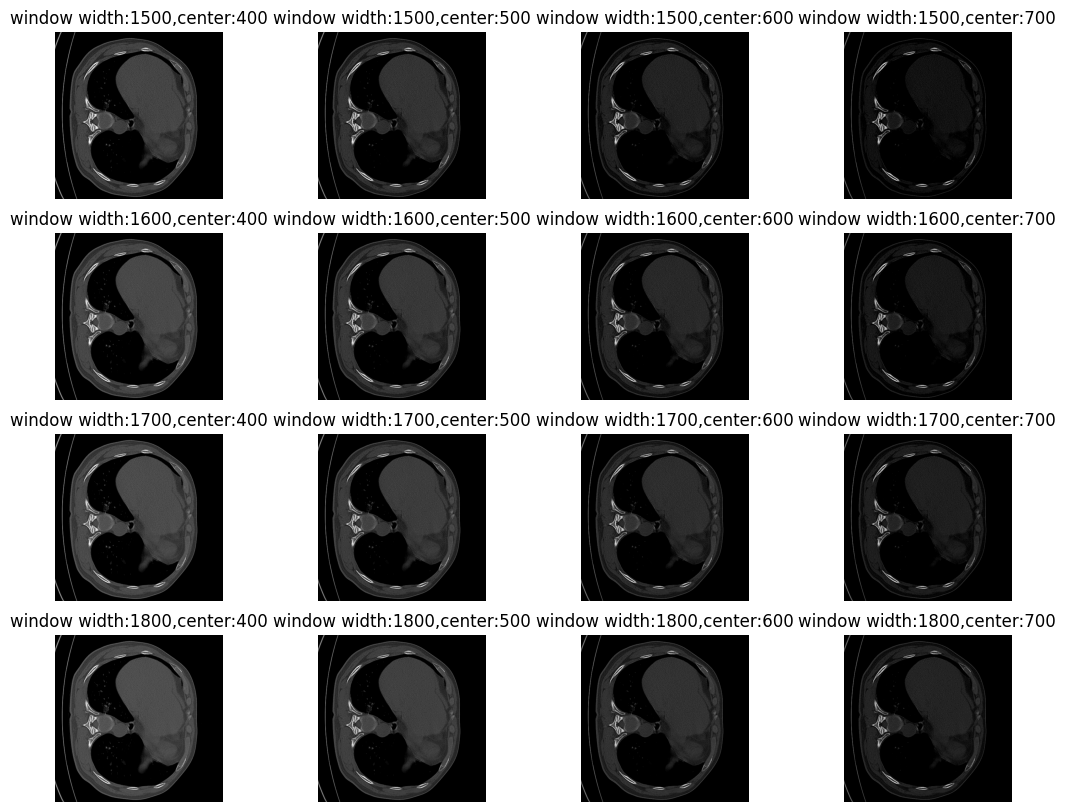

In [7]:


input_dir = "/home/qianq/data/corona_lung_seg"
output_dir = "/home/qianq/data/corona_lung_seg_png"
scan_dir = f"{input_dir}/ct_scans"
label_dir = f"{input_dir}/lung_mask"

i = 1
source_path = f"{scan_dir}/{ct_scans[i]}"
target_path = f"{label_dir}/{lung_mask[i]}"
source = read_nii_file(source_path)
target = read_nii_file(target_path)
slice_cnt = source.shape[2]
# for _index in range(slice_cnt):
_index = 57
source_img_arr = source.get_fdata()
target_img_arr = target.get_fdata()
single_source = get_nii_one_slice(source_img_arr, _index)

imgs = []
for window_width in window_width_choice:
    for window_center in window_center_choice:
        source_t = window_transform_single(single_source, window_width, window_center)
        imgs.append([source_t, window_width, window_center])
        # plot_img(source_t, title=f"window_width:{window_width}, window_center:{window_center}")
# single_target = nii_one_slice(target_img_arr, _index)
show_imgs(imgs, cols=4, figsize=(13, 10))

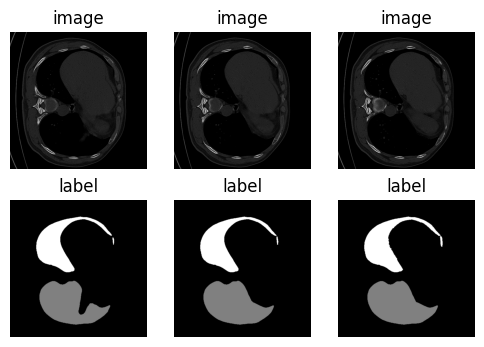

In [8]:
image_pairs = []
for i in range(3):
    image_pairs.append([
        window_transform_single(get_nii_one_slice(source_img_arr, _index+i), window_width, window_center),
        get_nii_one_slice(target_img_arr, _index+i),
    ])

show_image_pairs(image_pairs, figsize=(6, 4))